# change the script to address all 20 categories

In [1]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


import matplotlib.pyplot as plt
from collections import Counter


from sklearn.utils.extmath import density
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

class text_categorization:
    def __init__(self, verbose = False, categories=None, feature_type = "tf_idf", lowercasing = True, stop_words = "with", analyzer = "word", max_feature = None,
                 ngram_range=(1, 1)):
        self.verbose = verbose
        self.categories = categories
        self.feature_type = feature_type
        self.lowercasing = lowercasing
        self.stop_words = stop_words
        self.analyzer = analyzer
        self.max_feature = max_feature
        self.ngram_range = ngram_range
    
    @staticmethod
    def size_mb(docs):
        return sum(len(s.encode("utf-8")) for s in docs) / 1e6
    
    
    def load_dataset(self):
        data_train = fetch_20newsgroups(
            subset="train",
            categories= self.categories,
            shuffle=True,        
            random_state=42,        
            remove=(),                 
            )
        
        data_test = fetch_20newsgroups(        
            subset="test",        
            categories=self.categories,        
            shuffle=True,        
            random_state=42,        
            remove=(),     
            )
        
        target_names = data_train.target_names

        # split target in a training set and a test set    
        y_train, y_test = data_train.target, data_test.target
        

        # Extracting features from the training data using a sparse vectorizer    
        t0 = time()
        if self.analyzer == "words" and self.stop_words == "with":
            self.stop_words = "english"
        else:
            self.stop_words = None
        
        # set feature type 
        methods = {"Counts": CountVectorizer(max_df=0.5, min_df=5,
                                             lowercase=self.lowercasing, stop_words=self.stop_words, analyzer=self.analyzer, max_features=self.max_feature,                                     
                                             ngram_range=self.ngram_range),
                   "tf": TfidfVectorizer(sublinear_tf=True, use_idf=False, min_df=5,
                                         lowercase=self.lowercasing, stop_words=self.stop_words, analyzer=self.analyzer, max_features=self.max_feature,                                      
                                         ngram_range=self.ngram_range),    
                   "tf_idf": TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df=0.5, min_df=5,
                                             lowercase=self.lowercasing, stop_words=self.stop_words, analyzer=self.analyzer, max_features=self.max_feature,                                      
                                             ngram_range=self.ngram_range)
                   }
        
        # set the extractor
        vectorizer = methods[self.feature_type]
        X_train = vectorizer.fit_transform(data_train.data)
        duration_train = time() - t0

        # Extracting features from the test data using the same vectorizer
        t0 = time()    
        X_test = vectorizer.transform(data_test.data)    
        duration_test = time() - t0    
        feature_names = vectorizer.get_feature_names_out()

        if self.verbose:        
            # compute size of loaded data        
            data_train_size_mb = size_mb(data_train.data)        
            data_test_size_mb = size_mb(data_test.data)        
            print(            
                f"{len(data_train.data)} documents - "            
                f"{data_train_size_mb:.2f}MB (training set)"        
                )        
            
            print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")        
            print(f"{len(target_names)} categories")         
            print(            
                f"vectorize training done in {duration_train:.3f}s "            
                f"at {data_train_size_mb / duration_train:.3f}MB/s"        
                )        
            
            print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")        
            print(            
                f"vectorize testing done in {duration_test:.3f}s "            
                f"at {data_test_size_mb / duration_test:.3f}MB/s"        
                )        
            print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}") 
        
        return X_train, X_test, y_train, y_test, feature_names, target_names
    

    def y_balanced_check(self, y):
        # Count the occurrences of each class in y    
        class_counts = Counter(y)
        # Print the class distribution    
        print("Class distribution:")    
        for cls, count in class_counts.items():        
            print(f"Class {cls}: {count} samples")

        #Check if the dataset is balanced    
        most_common = max(class_counts.values())    
        least_common = min(class_counts.values())   
        balance_ratio = most_common / least_common 
        
        print(f"\nMost common class has {most_common} samples.")    
        print(f"Least common class has {least_common} samples.")    
        print(f"Balance ratio (most/least): {balance_ratio:.2f}")   
        
        # Visualize the distribution with a bar plot    
        plt.bar(class_counts.keys(), class_counts.values())    
        plt.xlabel('Classes')    
        plt.ylabel('Number of Samples')    
        plt.title('Class Distribution')    
        plt.show()   
        # Return True if the dataset is reasonably balanced    
        return balance_ratio <= 1.5
    

    # Benchmark the classifiers
    def benchmark(self, clf, custom_name=False):    
        print("_" * 80)    
        print("Training: ")    
        print(clf)   

        t0 = time()    
        clf.fit(X_train, y_train)    
        train_time = time() - t0    
        print(f"train time: {train_time:.3}s")    
        t0 = time()    
        pred = clf.predict(X_test)    
        test_time = time() - t0    
        print(f"test time:  {test_time:.3}s")    

        precision = precision_score(y_test, pred, average='macro')    
        print(f"Precision: {precision:.3}")     

        recall = recall_score(y_test, pred, average='macro') 
        print(f"Recall: {recall:.3}")

        F1_score = f1_score(y_test, pred, average = "macro")
        print(f"F1_score: {F1_score:.3f}")

        if hasattr(clf, "coef_"):        
            print(f"dimensionality: {clf.coef_.shape[1]}")        
            print(f"density: {density(clf.coef_)}")        
            print()
        
        print()     
        if custom_name:        
            clf_descr = str(custom_name)    
        else:        
            clf_descr = clf.__class__.__name__    
        
        return [clf_descr, precision, recall, F1_score, train_time, test_time]


    def result_unbalanced_y(self, clf_only = None):
        #Loop through the methods and print the results
        results = []

        # Convert to dense array if input data is sparse

        if clf_only == None:
            for clf, clf_name in (
                # Sparse naive Bayes classifier
            (ComplementNB(alpha=0.1), "Complement Naive Bayes"),
            # Non-linear random forest classifier
            (RandomForestClassifier(random_state=1), "Random Forest"),
            # L2 penalty Linear SVC
            (LinearSVC(C=0.1, dual=False, max_iter=10000, random_state=1), "Linear SVC"),):
                
                print("=" * 80)    
                print(clf_name)      
                results.append(self.benchmark(clf))

            #Find the best classifier and feature extraction method using the precision and recall score
            best_by_precision = max(results, key=lambda x: x[1])        
            best_by_recall = max(results, key=lambda x: x[2])        
            best_by_f1_score = max(results, key=lambda x: x[3])        
            
            #Print the best result for precision        
            print("Best by Precision:")        
            print(f"Classifier: {best_by_precision[0]}")        
            print(f"Precision: {best_by_precision[1]:.4f}")        
            print(f"Recall: {best_by_precision[2]:.4f}")        
            print(f"F1_score: {best_by_precision[3]:.4f}\n")        
            
            #Print the best result for recall        
            print("Best by Recall:")        
            print(f"Classifier: {best_by_recall[0]}")        
            print(f"Precision: {best_by_recall[1]:.4f}")        
            print(f"Recall: {best_by_recall[2]:.4f}")         
            print(f"F1_score: {best_by_recall[3]:.4f}\n")        
            
            #Print the best result for f1_score        
            print("Best by f1_score:")        
            print(f"Classifier: {best_by_f1_score[0]}")        
            print(f"Precision: {best_by_f1_score[1]:.4f}")        
            print(f"Recall: {best_by_f1_score[2]:.4f}")        
            print(f"F1_score: {best_by_f1_score[3]:.4f}\n")

        elif clf_only == "Linear SVC":
            clf = LinearSVC(C=0.1, dual=False, max_iter=1000)
            results.append(self.benchmark(clf))
            print(results)


        elif clf_only == "Random Forest":
            clf = RandomForestClassifier()
            results.append(self.benchmark(clf))
            print(results)

        elif clf_only == "ComplementNaive Bayes":
            clf = ComplementNB(alpha=0.1)
            results.append(self.benchmark(clf))
            print(results)


        


        return results




## Counts type

Class distribution:
Class 7: 594 samples
Class 4: 578 samples
Class 1: 584 samples
Class 14: 593 samples
Class 16: 546 samples
Class 13: 594 samples
Class 3: 590 samples
Class 2: 591 samples
Class 8: 598 samples
Class 19: 377 samples
Class 6: 585 samples
Class 0: 480 samples
Class 12: 591 samples
Class 5: 593 samples
Class 10: 600 samples
Class 9: 597 samples
Class 15: 599 samples
Class 17: 564 samples
Class 18: 465 samples
Class 11: 595 samples

Most common class has 600 samples.
Least common class has 377 samples.
Balance ratio (most/least): 1.59


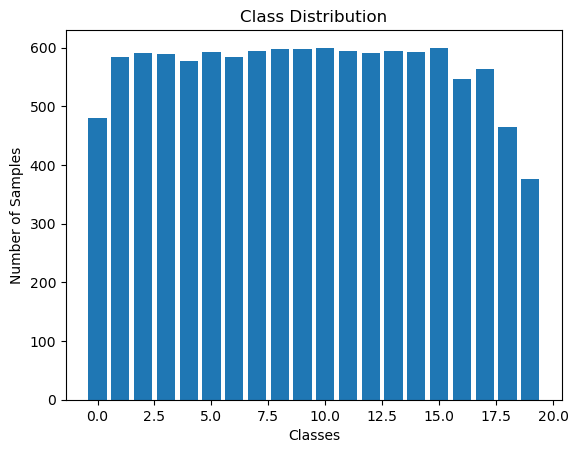

The train dataset is imbalanced.
Class distribution:
Class 7: 396 samples
Class 5: 395 samples
Class 0: 319 samples
Class 17: 376 samples
Class 19: 251 samples
Class 13: 396 samples
Class 15: 398 samples
Class 1: 389 samples
Class 2: 394 samples
Class 8: 398 samples
Class 4: 385 samples
Class 6: 390 samples
Class 16: 364 samples
Class 14: 394 samples
Class 3: 392 samples
Class 11: 396 samples
Class 9: 397 samples
Class 10: 399 samples
Class 18: 310 samples
Class 12: 393 samples

Most common class has 399 samples.
Least common class has 251 samples.
Balance ratio (most/least): 1.59


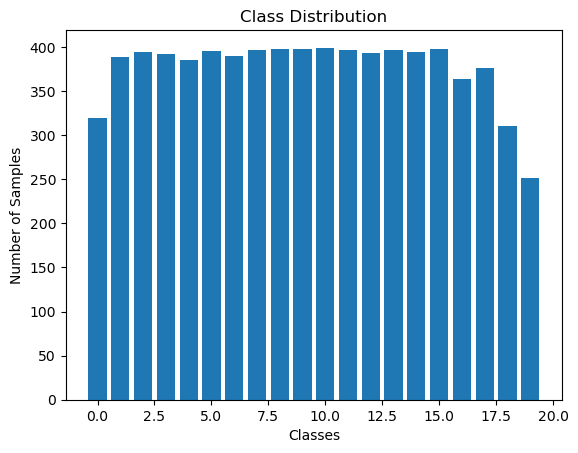

The dataset is imbalanced.


In [2]:
TextClassifier1 = text_categorization(verbose=False, feature_type="Counts")
X_train, X_test, y_train, y_test, feature_names, target_names = TextClassifier1.load_dataset()

is_balanced_train = TextClassifier1.y_balanced_check(y_train)
if is_balanced_train:
    print("The train dataset is balanced.")
else:
    print("The train dataset is imbalanced.")

is_balanced_test = TextClassifier1.y_balanced_check(y_test)
if is_balanced_test:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

In [3]:
TextClassifier1.result_unbalanced_y()

Complement Naive Bayes
________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.0808s
test time:  0.0269s
Precision: 0.814
Recall: 0.801
F1_score: 0.795

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=1)
train time: 77.5s
test time:  0.677s
Precision: 0.771
Recall: 0.754
F1_score: 0.753

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False, max_iter=10000, random_state=1)
train time: 3.18e+02s
test time:  0.0229s
Precision: 0.795
Recall: 0.79
F1_score: 0.790
dimensionality: 25914
density: 1.0


Best by Precision:
Classifier: ComplementNB
Precision: 0.8137
Recall: 0.8007
F1_score: 0.7954

Best by Recall:
Classifier: ComplementNB
Precision: 0.8137
Recall: 0.8007
F1_score: 0.7954

Best by f1_score:
Classifier: ComplementNB
Precision: 0.8137
Recall

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[['ComplementNB',
  0.8136524832594002,
  0.8006914020451552,
  0.7954187444413471,
  0.08081173896789551,
  0.026927947998046875],
 ['RandomForestClassifier',
  0.7714014378950529,
  0.7542370949610452,
  0.7533675595343498,
  77.48676657676697,
  0.677192211151123],
 ['LinearSVC',
  0.7946572964160316,
  0.79014373876401,
  0.7903160674170805,
  317.6785569190979,
  0.02293872833251953]]

# TF

Class distribution:
Class 7: 594 samples
Class 4: 578 samples
Class 1: 584 samples
Class 14: 593 samples
Class 16: 546 samples
Class 13: 594 samples
Class 3: 590 samples
Class 2: 591 samples
Class 8: 598 samples
Class 19: 377 samples
Class 6: 585 samples
Class 0: 480 samples
Class 12: 591 samples
Class 5: 593 samples
Class 10: 600 samples
Class 9: 597 samples
Class 15: 599 samples
Class 17: 564 samples
Class 18: 465 samples
Class 11: 595 samples

Most common class has 600 samples.
Least common class has 377 samples.
Balance ratio (most/least): 1.59


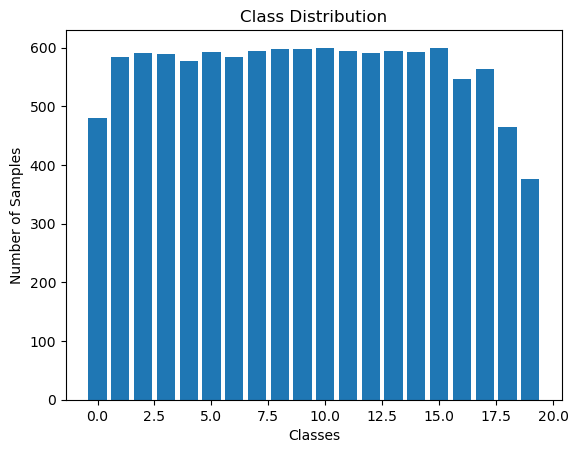

The train dataset is imbalanced.
Class distribution:
Class 7: 396 samples
Class 5: 395 samples
Class 0: 319 samples
Class 17: 376 samples
Class 19: 251 samples
Class 13: 396 samples
Class 15: 398 samples
Class 1: 389 samples
Class 2: 394 samples
Class 8: 398 samples
Class 4: 385 samples
Class 6: 390 samples
Class 16: 364 samples
Class 14: 394 samples
Class 3: 392 samples
Class 11: 396 samples
Class 9: 397 samples
Class 10: 399 samples
Class 18: 310 samples
Class 12: 393 samples

Most common class has 399 samples.
Least common class has 251 samples.
Balance ratio (most/least): 1.59


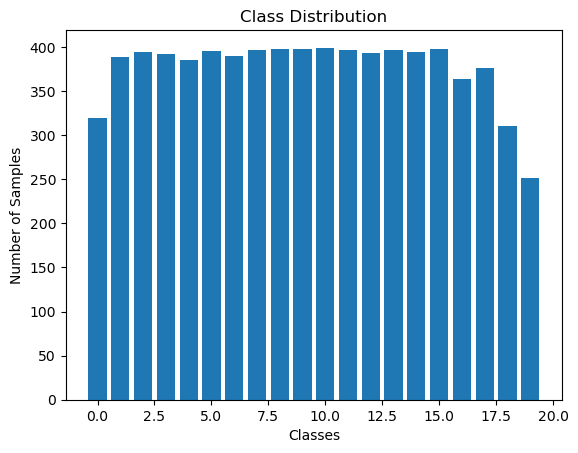

The dataset is imbalanced.


In [4]:
TextClassifier2 = text_categorization(verbose=False, feature_type="tf")
X_train, X_test, y_train, y_test, feature_names, target_names = TextClassifier2.load_dataset()

is_balanced_train = TextClassifier2.y_balanced_check(y_train)
if is_balanced_train:
    print("The train dataset is balanced.")
else:
    print("The train dataset is imbalanced.")

is_balanced_test = TextClassifier2.y_balanced_check(y_test)
if is_balanced_test:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

In [5]:
TextClassifier2.result_unbalanced_y()

Complement Naive Bayes
________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.0588s
test time:  0.02s
Precision: 0.843
Recall: 0.831
F1_score: 0.830

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=1)
train time: 82.6s
test time:  0.724s
Precision: 0.758
Recall: 0.744
F1_score: 0.743

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False, max_iter=10000, random_state=1)
train time: 5.72s
test time:  0.0209s
Precision: 0.808
Recall: 0.795
F1_score: 0.794
dimensionality: 25941
density: 1.0


Best by Precision:
Classifier: ComplementNB
Precision: 0.8434
Recall: 0.8307
F1_score: 0.8298

Best by Recall:
Classifier: ComplementNB
Precision: 0.8434
Recall: 0.8307
F1_score: 0.8298

Best by f1_score:
Classifier: ComplementNB
Precision: 0.8434
Recall: 0.8

[['ComplementNB',
  0.8433773913928186,
  0.8307371886310613,
  0.8298220501576303,
  0.05884265899658203,
  0.01997852325439453],
 ['RandomForestClassifier',
  0.7577380573462169,
  0.7438837797673261,
  0.743144386614927,
  82.63695502281189,
  0.7240638732910156],
 ['LinearSVC',
  0.8082222332453721,
  0.7952530453797737,
  0.7941338014153427,
  5.716753959655762,
  0.02094101905822754]]

# tf-idf

Class distribution:
Class 7: 594 samples
Class 4: 578 samples
Class 1: 584 samples
Class 14: 593 samples
Class 16: 546 samples
Class 13: 594 samples
Class 3: 590 samples
Class 2: 591 samples
Class 8: 598 samples
Class 19: 377 samples
Class 6: 585 samples
Class 0: 480 samples
Class 12: 591 samples
Class 5: 593 samples
Class 10: 600 samples
Class 9: 597 samples
Class 15: 599 samples
Class 17: 564 samples
Class 18: 465 samples
Class 11: 595 samples

Most common class has 600 samples.
Least common class has 377 samples.
Balance ratio (most/least): 1.59


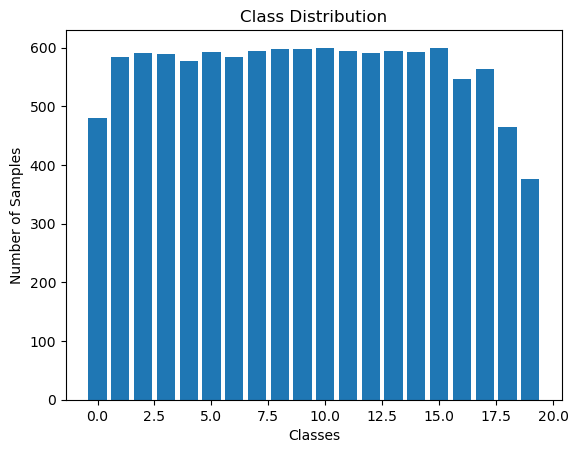

The train dataset is imbalanced.
Class distribution:
Class 7: 396 samples
Class 5: 395 samples
Class 0: 319 samples
Class 17: 376 samples
Class 19: 251 samples
Class 13: 396 samples
Class 15: 398 samples
Class 1: 389 samples
Class 2: 394 samples
Class 8: 398 samples
Class 4: 385 samples
Class 6: 390 samples
Class 16: 364 samples
Class 14: 394 samples
Class 3: 392 samples
Class 11: 396 samples
Class 9: 397 samples
Class 10: 399 samples
Class 18: 310 samples
Class 12: 393 samples

Most common class has 399 samples.
Least common class has 251 samples.
Balance ratio (most/least): 1.59


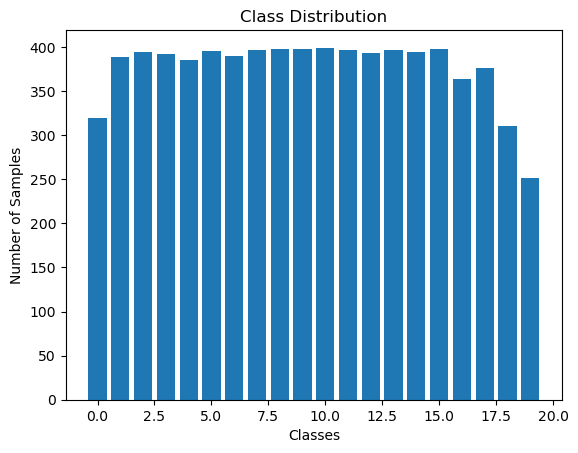

The dataset is imbalanced.


In [6]:
TextClassifier3 = text_categorization(verbose=False)
X_train, X_test, y_train, y_test, feature_names, target_names = TextClassifier3.load_dataset()

is_balanced_train = TextClassifier3.y_balanced_check(y_train)
if is_balanced_train:
    print("The train dataset is balanced.")
else:
    print("The train dataset is imbalanced.")

is_balanced_test = TextClassifier3.y_balanced_check(y_test)
if is_balanced_test:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")


In [7]:
Result = TextClassifier3.result_unbalanced_y()

Complement Naive Bayes
________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.0539s
test time:  0.0199s
Precision: 0.83
Recall: 0.821
F1_score: 0.820

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier(random_state=1)
train time: 76.9s
test time:  0.677s
Precision: 0.767
Recall: 0.751
F1_score: 0.750

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False, max_iter=10000, random_state=1)
train time: 4.35s
test time:  0.0199s
Precision: 0.849
Recall: 0.838
F1_score: 0.839
dimensionality: 25914
density: 1.0


Best by Precision:
Classifier: LinearSVC
Precision: 0.8490
Recall: 0.8384
F1_score: 0.8390

Best by Recall:
Classifier: LinearSVC
Precision: 0.8490
Recall: 0.8384
F1_score: 0.8390

Best by f1_score:
Classifier: LinearSVC
Precision: 0.8490
Recall: 0.8384
F1_s

In [8]:
Result

[['ComplementNB',
  0.8300802299940351,
  0.8206383027338895,
  0.8195888250201155,
  0.05388689041137695,
  0.019915103912353516],
 ['RandomForestClassifier',
  0.7665843016543438,
  0.751076313805252,
  0.7496864583829241,
  76.93336296081543,
  0.6772217750549316],
 ['LinearSVC',
  0.84901575972759,
  0.8383565829347877,
  0.8390453565354614,
  4.354357004165649,
  0.019945859909057617]]

# The best model is linearSVC with tf-idf
varying across the lowercasing, stop_words, analyzer and max_Feature

In [10]:
import pandas as pd
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from time import time

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

Grid_Results = pd.DataFrame(columns=['lowerCasing', 'stop_words', "ngram_range", "analyzer", "max_features", "clf_descr", "precision", "recall", "F1_score", "train_time", "test_time"])

# Parameter grid
lowercase_options = [True, False]
stop_words_options = ["with", "without"]
analyzer_options = ['word', 'char', 'char_wb']
ngram_range_options = [(1, 1), (1, 2), (2, 2)]
max_features_options = [None, 5000, 10000, 15000]

for lowcase in lowercase_options:
    for stop_words in stop_words_options:
        for analyzer in analyzer_options:
            for ngram_range in ngram_range_options:
                for max_features in max_features_options:
                    TextClassifier_grid = text_categorization(lowercasing=lowcase, stop_words=stop_words, analyzer=analyzer, ngram_range=ngram_range, max_feature=max_features)
                    X_train, X_test, y_train, y_test, feature_names, target_names = TextClassifier_grid.load_dataset()
                    Result = TextClassifier_grid.result_unbalanced_y(clf_only="Linear SVC")
                    new_row = pd.DataFrame({"lowerCasing": [lowcase], "stop_words": [stop_words], "ngram_range":[ngram_range.index(ngram_range)],
                                                "analyzer": [analyzer], "max_features": [max_features], "clf_descr": Result[0], "precision":Result[1], "recall":Result[2],
                                                "F1_score":Result[3], "train_time":Result[4], "test_time":Result[5]})
                                
                    Grid_Results = pd.concat([Grid_Results, new_row], ignore_index=True)


Grid_Results.to_csv("Grid_Results.csv", index = False)
Grid_Results.head()


________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time: 4.33s
test time:  0.0199s
Precision: 0.849
Recall: 0.838
F1_score: 0.839
dimensionality: 25914
density: 1.0


[['LinearSVC', 0.84901575972759, 0.8383565829347877, 0.8390453565354614, 4.334383249282837, 0.019948244094848633]]


NameError: name 'case' is not defined

In [23]:
import pandas as pd
Result = pd.DataFrame(columns=['feature_type', 'lowerCasing', 'stop_words', "ngram_range", "analyzer", "max_features", "classifier_Name", "classifier_Metric", "score"])
for feat in feature_type:
    for case in lowerCasing:
        for stop in stop_words:
            for ngram in ngram_range:
                for ana in analyzer:
                    for max in max_features:
                        X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=False, remove=(), features = feat, Lowercasing = case, Stop_words = stop, Analyzer = ana, Max_feature = max, Ngram_range = ngram)
                        print(f"feature: {feat}, LowerCasing: {case}, stop_words: {stop}, ngram_range:{ngram}, analyzer:{ana}, max_feature:{max}", "has loaded the data!!!")
                        for name in classifier_Name:
                            y_pred = classifier_modelling(classifierName = "MultinomialNB", X_train = X_train, y_train = y_train, X_test = X_test)
                            print(f"classifier: {name}", "has finished model building!!!")
                            for metric in classifier_Metric:
                                score = classifier_evaluation(metric=metric, y_pred=y_pred, y_test=y_test)
                                print(score)
                                new_row = pd.DataFrame({"feature_type": [feat], "lowerCasing": [case], "stop_words": [stop], "ngram_range":[ngram_range.index(ngram)],
                                                "analyzer": [ana], "max_features": [max], "classifier_Name":[name], "classifier_Metric":[metric], "score":[score]})
                                
                                Result = pd.concat([Result, new_row], ignore_index=True)
                                

TypeError: load_dataset() got an unexpected keyword argument 'verbose'

In [ ]:
Result

In [6]:
Result.to_csv("Result.csv", index = False)